# 002: Encounter Detection

**Systematic search for gradient kick signatures**

## The Question

Do any dead tokens show evidence of rare prediction encounters (sharp gradient spikes) after early training?

## The Signature

An encounter should look like:
- **Early phase (t < threshold):** Smooth thermal decay, all tokens similar
- **Encounter event:** Sudden gradient spike (orders of magnitude above baseline)
- **Post-encounter:** Token continues with higher baseline (now distinguishable) or returns to thermal (prediction was fluke)

## Search Strategy

1. Compute gradient magnitude timeline for all 51 dead tokens
2. Identify baseline thermal noise level (median gradient in late training)
3. Search for spikes: gradients significantly above baseline after t > threshold
4. Rank tokens by: (a) number of spikes, (b) spike magnitude, (c) spike timing
5. Visualize top candidates

## Parameters to tune

- **Thermal phase threshold:** When does early uniform training end? (t=10? 100? 1000?)
- **Spike threshold:** How many σ above baseline counts as encounter? (3σ? 5σ? 10σ?)
- **Minimum spike magnitude:** Absolute floor to avoid noise (1e-6? 1e-5?)

## Parameters

In [15]:
DATA_PATH = "../tensors/Lil_Gatsby/1.9b_training_data.safetensors"

# Encounter detection parameters
THERMAL_PHASE_END = 1500  # After this step, look for encounters
BASELINE_WINDOW = (5000, 10000)  # Steps to compute thermal baseline (late training)
SPIKE_SIGMA_THRESHOLD = 5.0  # How many std devs above baseline
MIN_SPIKE_MAGNITUDE = 1e-6  # Absolute minimum to count as spike

# Visualization
TOP_N_TOKENS = 5  # Show this many tokens with most encounters
FIGSIZE = (16, 12)
DPI = 150

## Imports

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from safetensors import safe_open
from pathlib import Path
from collections import defaultdict

## Device Detection

In [17]:
if torch.cuda.is_available():
    device = 'cuda'
elif torch.backends.mps.is_available():
    device = 'mps'
else:
    device = 'cpu'

print(f"Using device: {device}")

Using device: mps


## Load Data

In [18]:
data_path = Path(DATA_PATH)

print(f"Loading: {data_path}")

with safe_open(data_path, framework='pt', device='cpu') as f:
    embeddings = f.get_tensor('embeddings').to(device)  # (10001, 128, 64)
    grads = f.get_tensor('grads').to(device)  # (10001, 128, 64)
    dead_token_ids = f.get_tensor('dead_token_ids')  # (51,)
    recorded_steps = f.get_tensor('recorded_steps')  # (10001,)

n_steps, vocab_size, d = embeddings.shape

print(f"\nLoaded {n_steps} timesteps, {len(dead_token_ids)} dead tokens")

Loading: ../tensors/Lil_Gatsby/1.9b_training_data.safetensors

Loaded 100001 timesteps, 50 dead tokens


## Compute Gradient Magnitudes for All Dead Tokens

In [19]:
print("Computing gradient magnitudes...")

# Extract gradients for dead tokens only: (n_steps, n_dead, d)
dead_grads = grads[:, dead_token_ids, :]

# Compute L2 norm: (n_steps, n_dead)
grad_mags = torch.linalg.vector_norm(dead_grads, dim=2).cpu().numpy()

print(f"✓ Gradient magnitudes: {grad_mags.shape}")
print(f"  Shape: (timesteps={grad_mags.shape[0]}, dead_tokens={grad_mags.shape[1]})")

Computing gradient magnitudes...
✓ Gradient magnitudes: (100001, 50)
  Shape: (timesteps=100001, dead_tokens=50)


## Compute Thermal Baseline

For each token, what's the typical gradient magnitude in late training (when things have settled)?

In [20]:
# Get baseline window
baseline_start, baseline_end = BASELINE_WINDOW
baseline_mask = (recorded_steps >= baseline_start) & (recorded_steps <= baseline_end)
baseline_indices = torch.where(baseline_mask)[0].numpy()

print(f"Baseline window: steps {baseline_start}-{baseline_end}")
print(f"  {len(baseline_indices)} timesteps in baseline")

# Compute baseline statistics for each token
baseline_grads = grad_mags[baseline_indices, :]  # (baseline_steps, n_dead)

baseline_median = np.median(baseline_grads, axis=0)  # (n_dead,)
baseline_std = np.std(baseline_grads, axis=0)  # (n_dead,)

print(f"\nBaseline statistics:")
print(f"  Median gradient: {np.median(baseline_median):.6e}")
print(f"  Typical std dev: {np.median(baseline_std):.6e}")

Baseline window: steps 5000-10000
  5000 timesteps in baseline

Baseline statistics:
  Median gradient: 7.965654e-04
  Typical std dev: 2.314438e-05


## Detect Encounters

Find gradient spikes after thermal phase ends.

In [21]:
# Get search window (after thermal phase)
search_mask = recorded_steps.numpy() > THERMAL_PHASE_END
search_indices = np.where(search_mask)[0]

print(f"\nSearching for encounters after step {THERMAL_PHASE_END}")
print(f"  {len(search_indices)} timesteps to search")

# For each token, find spikes
encounters = defaultdict(list)  # token_idx → [(step, magnitude), ...]

for token_idx in range(len(dead_token_ids)):
    token_id = dead_token_ids[token_idx].item()
    
    # Get this token's baseline
    median = baseline_median[token_idx]
    std = baseline_std[token_idx]
    
    # Threshold: median + N*sigma, with absolute minimum
    threshold = max(median + SPIKE_SIGMA_THRESHOLD * std, MIN_SPIKE_MAGNITUDE)
    
    # Find spikes in search window
    for step_idx in search_indices:
        grad_mag = grad_mags[step_idx, token_idx]
        
        if grad_mag > threshold:
            step = recorded_steps[step_idx].item()
            encounters[token_idx].append((step, grad_mag))

# Count encounters per token
encounter_counts = {tok_idx: len(spikes) for tok_idx, spikes in encounters.items()}

print(f"\n✓ Encounter detection complete")
print(f"  {len(encounter_counts)} tokens with encounters")
print(f"  Total encounters found: {sum(encounter_counts.values())}")


Searching for encounters after step 1500
  98500 timesteps to search

✓ Encounter detection complete
  50 tokens with encounters
  Total encounters found: 117296


## Rank Tokens by Encounter Activity

In [22]:
# Sort tokens by number of encounters
ranked_tokens = sorted(encounter_counts.items(), key=lambda x: x[1], reverse=True)

print(f"\nTop {min(TOP_N_TOKENS, len(ranked_tokens))} tokens by encounter count:\n")

for i, (token_idx, count) in enumerate(ranked_tokens[:TOP_N_TOKENS]):
    token_id = dead_token_ids[token_idx].item()
    spikes = encounters[token_idx]
    
    # Get spike stats
    magnitudes = [mag for step, mag in spikes]
    max_mag = max(magnitudes) if magnitudes else 0
    first_step = min(step for step, mag in spikes) if spikes else 0
    
    print(f"  {i+1}. Token {token_id} (index {token_idx}):")
    print(f"     Encounters: {count}")
    print(f"     Max spike: {max_mag:.6e}")
    print(f"     First encounter: step {first_step}")
    print()


Top 5 tokens by encounter count:

  1. Token 3 (index 3):
     Encounters: 2395
     Max spike: 9.557376e-04
     First encounter: step 18648

  2. Token 11 (index 10):
     Encounters: 2395
     Max spike: 9.557376e-04
     First encounter: step 18648

  3. Token 23 (index 21):
     Encounters: 2395
     Max spike: 9.557376e-04
     First encounter: step 18648

  4. Token 34 (index 30):
     Encounters: 2395
     Max spike: 9.557376e-04
     First encounter: step 18648

  5. Token 43 (index 35):
     Encounters: 2395
     Max spike: 9.557376e-04
     First encounter: step 18648



## Visualize Top Encounter Candidates

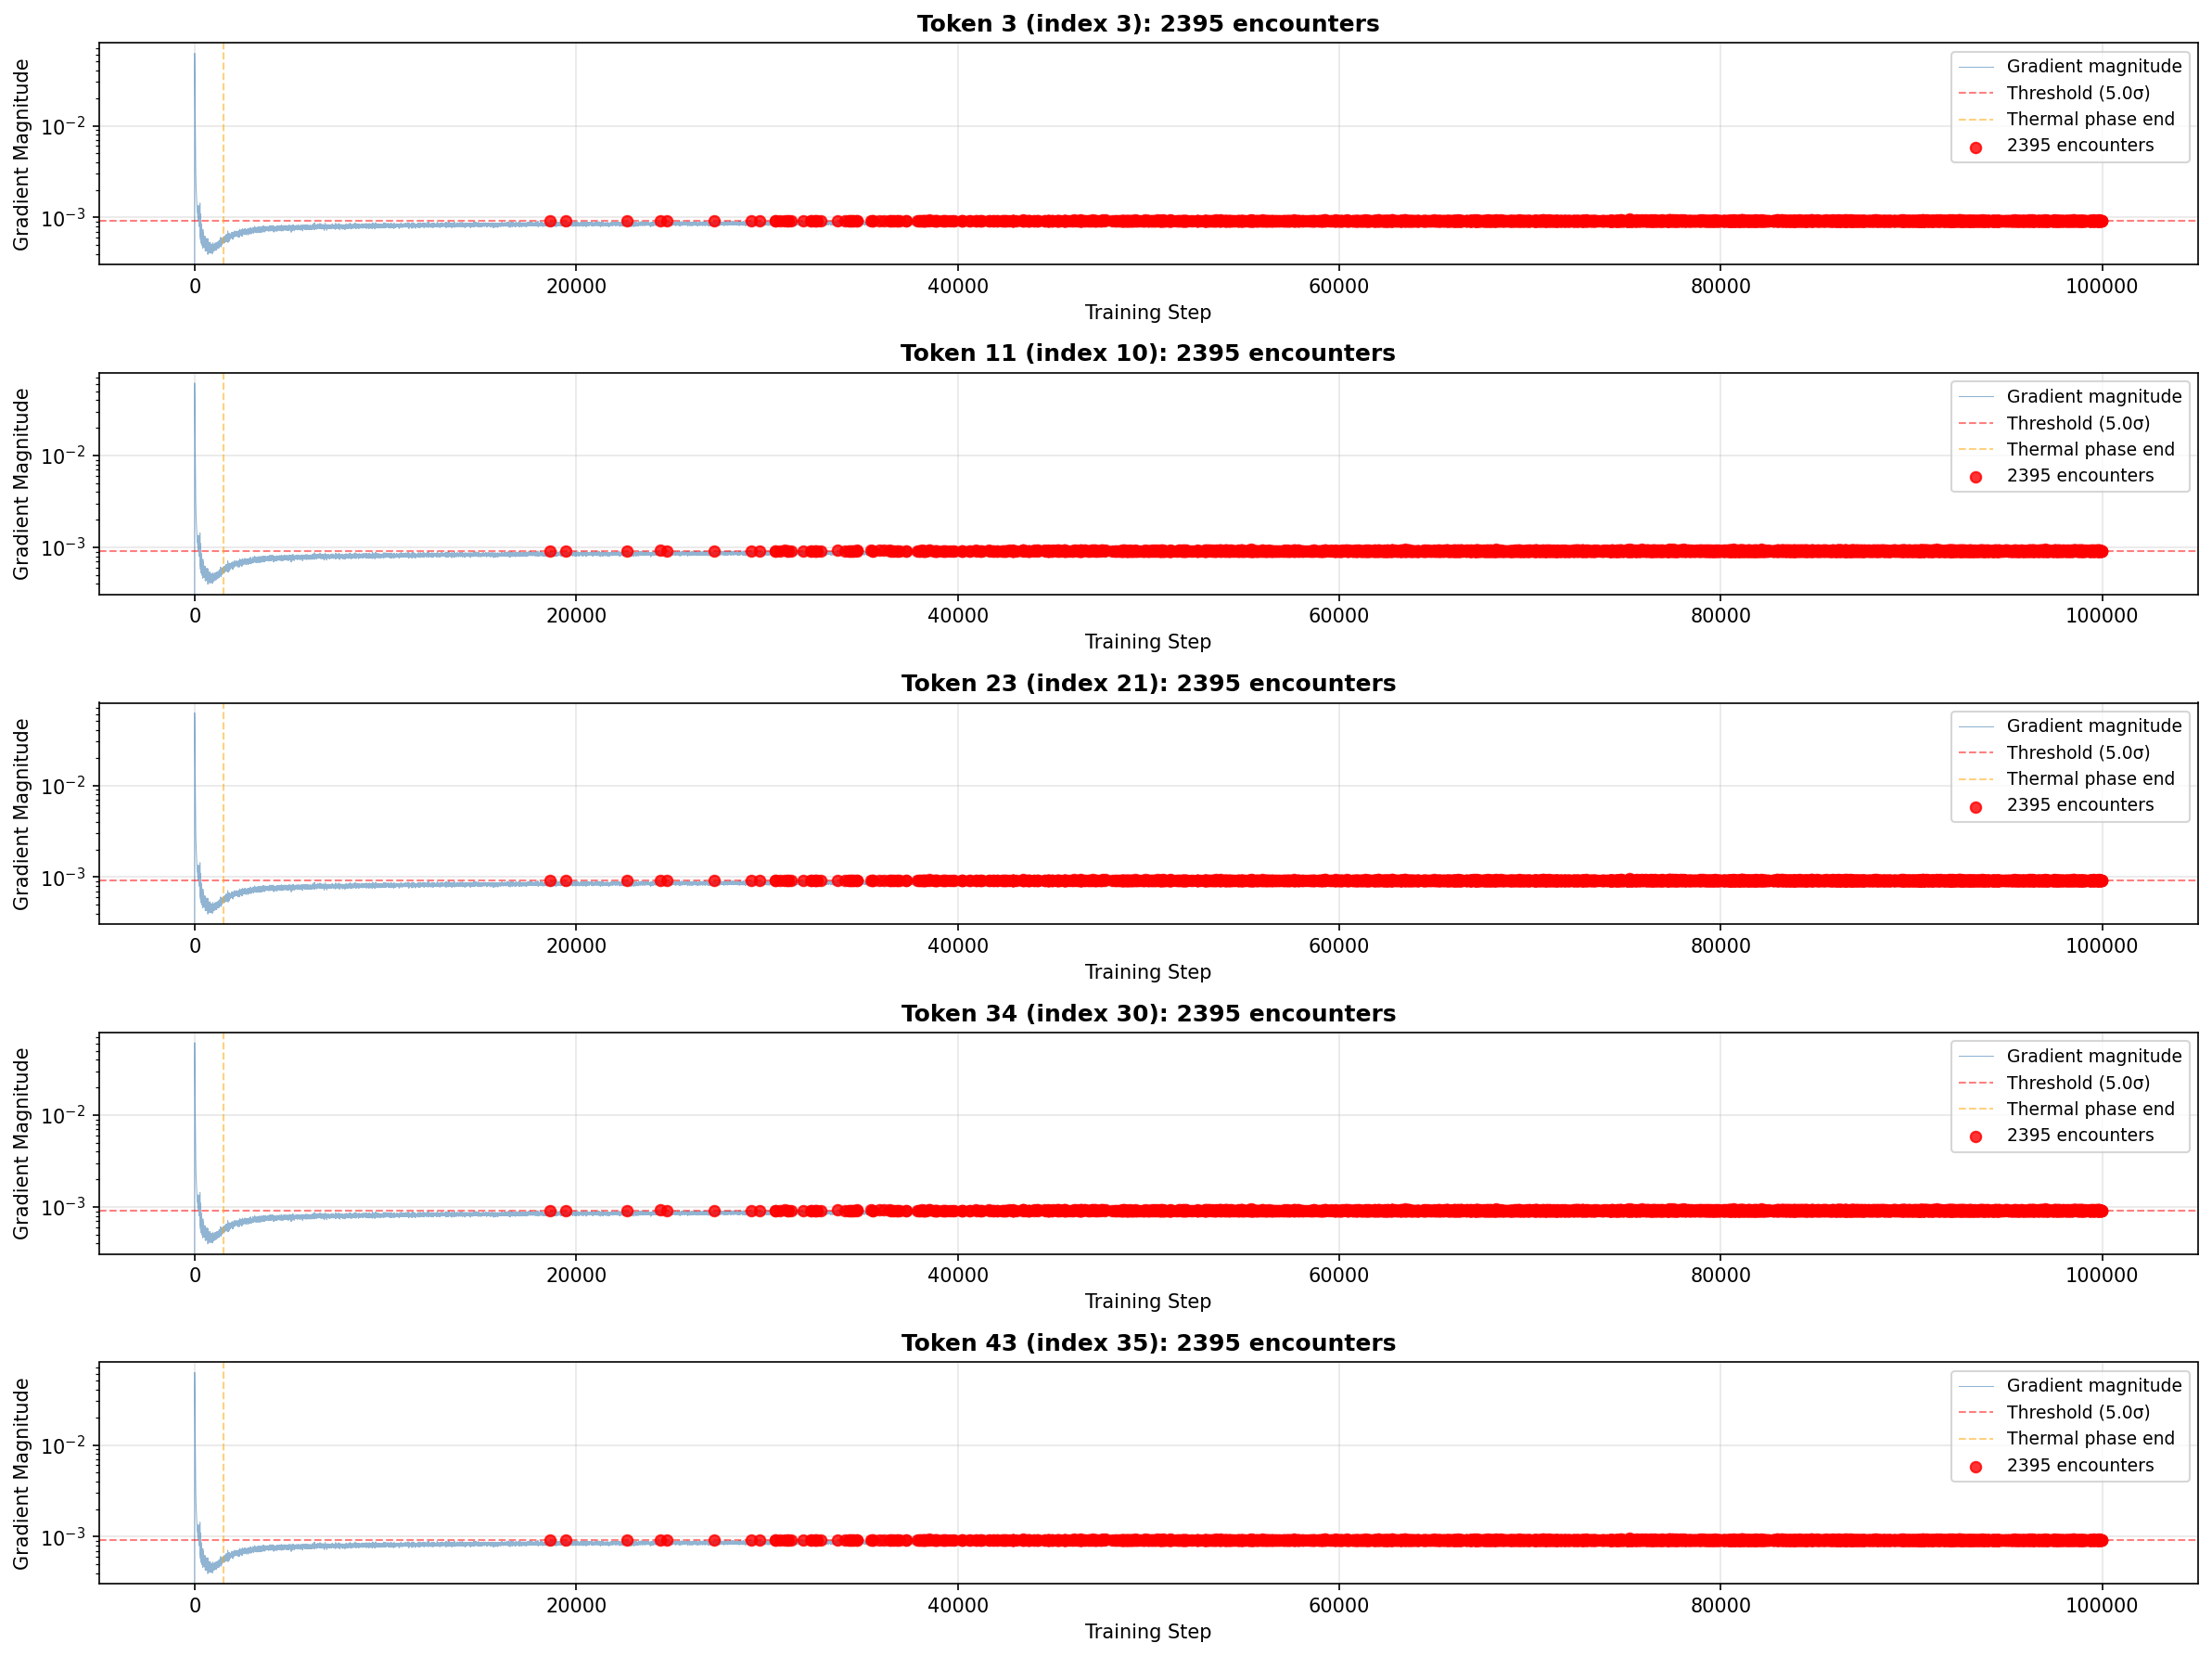


✓ Visualization complete


In [29]:
if len(ranked_tokens) > 0:
    n_plots = min(TOP_N_TOKENS, len(ranked_tokens))
    
    fig, axes = plt.subplots(n_plots, 1, figsize=FIGSIZE, dpi=DPI)
    
    if n_plots == 1:
        axes = [axes]  # Make iterable
    
    steps = recorded_steps.cpu().numpy()
    
    for i, (token_idx, count) in enumerate(ranked_tokens[:n_plots]):
        token_id = dead_token_ids[token_idx].item()
        ax = axes[i]
        
        # Plot full gradient trajectory
        ax.plot(steps, grad_mags[:, token_idx], color='steelblue', 
                linewidth=0.5, alpha=0.6, label='Gradient magnitude')
        
        # Mark baseline threshold
        median = baseline_median[token_idx]
        std = baseline_std[token_idx]
        threshold = max(median + SPIKE_SIGMA_THRESHOLD * std, MIN_SPIKE_MAGNITUDE)
        
        ax.axhline(threshold, color='red', linestyle='--', linewidth=1.0, 
                   alpha=0.5, label=f'Threshold ({SPIKE_SIGMA_THRESHOLD}σ)')
        
        # Mark thermal phase end
        ax.axvline(THERMAL_PHASE_END, color='orange', linestyle='--', 
                   linewidth=1.0, alpha=0.5, label='Thermal phase end')
        
        # Highlight encounter events
        if token_idx in encounters:
            encounter_steps = [step for step, mag in encounters[token_idx]]
            encounter_mags = [mag for step, mag in encounters[token_idx]]
            ax.scatter(encounter_steps, encounter_mags, color='red', 
                      s=30, alpha=0.8, zorder=5, label=f'{count} encounters')
        
        ax.set_xlabel('Training Step')
        ax.set_ylabel('Gradient Magnitude')
        ax.set_title(f'Token {token_id} (index {token_idx}): {count} encounters', 
                    fontweight='bold')
        ax.set_yscale('log')
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Visualization complete")
else:
    print("\n⚠️  No encounters found with current parameters")
    print("    Try adjusting:")
    print(f"    - THERMAL_PHASE_END (currently {THERMAL_PHASE_END})")
    print(f"    - SPIKE_SIGMA_THRESHOLD (currently {SPIKE_SIGMA_THRESHOLD})")
    print(f"    - MIN_SPIKE_MAGNITUDE (currently {MIN_SPIKE_MAGNITUDE})")

## Summary Statistics

In [30]:
if len(encounter_counts) > 0:
    total_encounters = sum(encounter_counts.values())
    tokens_with_encounters = len(encounter_counts)
    tokens_without = len(dead_token_ids) - tokens_with_encounters
    
    print(f"\n=== Encounter Summary ===")
    print(f"\nParameters:")
    print(f"  Thermal phase end: step {THERMAL_PHASE_END}")
    print(f"  Spike threshold: {SPIKE_SIGMA_THRESHOLD}σ above baseline")
    print(f"  Minimum magnitude: {MIN_SPIKE_MAGNITUDE:.6e}")
    print(f"\nResults:")
    print(f"  Total encounters: {total_encounters}")
    print(f"  Tokens with encounters: {tokens_with_encounters}/{len(dead_token_ids)} ({100*tokens_with_encounters/len(dead_token_ids):.1f}%)")
    print(f"  Tokens without encounters: {tokens_without}/{len(dead_token_ids)} ({100*tokens_without/len(dead_token_ids):.1f}%)")
    print(f"  Mean encounters per token (w/ encounters): {total_encounters/tokens_with_encounters:.1f}")
else:
    print("\n⚠️  No encounters detected. Hypothesis may be falsified, or parameters need tuning.")


=== Encounter Summary ===

Parameters:
  Thermal phase end: step 1500
  Spike threshold: 5.0σ above baseline
  Minimum magnitude: 1.000000e-06

Results:
  Total encounters: 117296
  Tokens with encounters: 50/50 (100.0%)
  Tokens without encounters: 0/50 (0.0%)
  Mean encounters per token (w/ encounters): 2345.9


## Interpretation

**If we find encounters:**
- Do they correlate with tokens that escaped (singletons vs BH members)?
- Do early encounters predict larger final distances?
- Is there a temporal pattern (clustering in time)?

**If we find NO encounters:**
- Dead tokens may never get predicted (too buried in singularity)
- Escape mechanism may be pure thermal diffusion (no kicks)
- Hypothesis needs revision

**Next steps:**
- Correlate encounter count with final BH membership (001 can identify who escaped)
- Check if encounter timing predicts escape timing (distance trajectory)
- Compare encounter tokens vs non-encounter tokens: any geometric differences?